# 模型评估

1. 想要计算混淆矩阵，要先进行test导出推理结果，这里导出的文件由--out指定

In [1]:
# !python ../tools/test.py \
# ../configs/mel/efficientnet-b0_8xb32_isic2018task3.py \
# ../work_dirs/efficientnet-b0_8xb32_isic2018task3/epoch_55.pth \
# --out efficientnet-b0_result.pkl

In [2]:
import mmcv
from mmcls.datasets import build_dataset
from mmcls.core.evaluation import calculate_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from sklearn import metrics



/home/fate/.conda/envs/mmcls_0/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fate/.conda/envs/mmcls_0/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
# constant
cfg_pth = '../configs/mel/efficientnet-b0_8xb32_imagenet_asan.py'
pkl_pth = 'experiment7/efficient-b0_result.pkl'

classes = ['nv', 'mel']


1. expose confusion matrix

In [4]:
# 配置文件路径
cfg = mmcv.Config.fromfile(cfg_pth)
dataset = build_dataset(cfg.data.test)

pred = mmcv.load(pkl_pth)['class_scores']

pred = torch.from_numpy(pred)
pred_label = torch.argmax(pred, dim=1).flatten()

target = torch.from_numpy(dataset.get_gt_labels())
target_label = target.flatten()
matrix = calculate_confusion_matrix(pred, dataset.get_gt_labels())
matrix # 由此可以计算指标。
# [
#     [TN, FP],
#     [FN, TP],
# ]





tensor([[223,  12],
        [ 11,  48]])

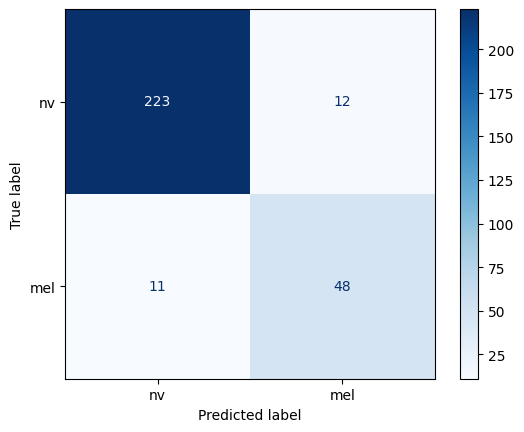

In [5]:


# 使用sklearn工具中confusion_matrix方法计算混淆矩阵
confusion_mat = confusion_matrix(target_label, pred_label)

# 使用sklearn工具包中的ConfusionMatrixDisplay可视化混淆矩阵，参考plot_confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
disp.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="Blues",                   # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d"               # 显示的数值格式
)
plt.show()

2. get metrics: acc, precision, recall, f1_score, f2_score

In [6]:
# 总体acc
acc = metrics.accuracy_score(target_label, pred_label)
# positive的precision recall f1 f2
recall = metrics.recall_score(target_label, pred_label, pos_label = 1)
precision = metrics.precision_score(target_label, pred_label, pos_label = 1)
f1_score = metrics.f1_score(target_label, pred_label, pos_label = 1)
f2_score = metrics.fbeta_score(target_label, pred_label, beta=2, pos_label = 1)



3. get auc and roc curve

fpr 真正率 = 灵敏度 = recall

假正率（FPR） = 1- 特异度 = FP/(FP+TN)

如何根据roc曲线选择高recall模型：https://blog.csdn.net/m0_55097528/article/details/125122744

In [7]:
fpr, tpr, threshold = metrics.roc_curve(target_label, pred_label, pos_label = 1)
auc = metrics.auc(fpr, tpr)




In [8]:
print(
    '''
accuracy\t{:.2%}
precision\t{:.2%}
recall\t{:.2%}
f1-score\t{:.2%}
f2-score\t{:.2%}
auc\t{:.2%}
    '''.format(acc, precision, recall, f1_score, f2_score, auc)
)


accuracy	92.18%
precision	80.00%
recall	81.36%
f1-score	80.67%
f2-score	81.08%
auc	88.12%
    


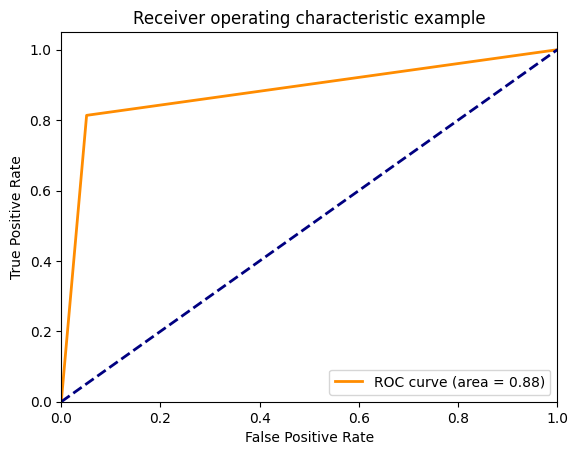

In [9]:
# 画出roc 曲线

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


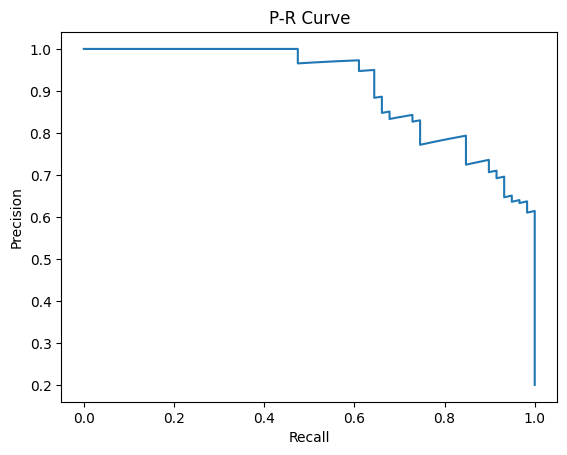

array([9.65656909e-07, 1.32303660e-06, 1.46631555e-06, 1.46871980e-06,
       2.27663622e-06, 2.29581860e-06, 3.25267297e-06, 3.45772946e-06,
       3.89564093e-06, 3.97291888e-06, 4.57911301e-06, 4.73333057e-06,
       4.83086387e-06, 5.01781096e-06, 5.10139535e-06, 5.23937206e-06,
       5.48728030e-06, 5.52858228e-06, 5.59160117e-06, 5.74127034e-06,
       5.87609748e-06, 6.05592550e-06, 6.42963732e-06, 6.81262236e-06,
       7.37349228e-06, 7.47432341e-06, 8.51606455e-06, 8.59819284e-06,
       9.57385510e-06, 9.67420692e-06, 1.04507590e-05, 1.04907931e-05,
       1.07486812e-05, 1.09874181e-05, 1.10440296e-05, 1.10474739e-05,
       1.13678461e-05, 1.17662266e-05, 1.18054868e-05, 1.31328434e-05,
       1.34067623e-05, 1.40509328e-05, 1.56350779e-05, 1.58331841e-05,
       1.62008655e-05, 1.79135641e-05, 1.85176705e-05, 2.10904655e-05,
       2.12272334e-05, 2.16279841e-05, 2.25742751e-05, 2.43050617e-05,
       2.85436254e-05, 3.03417928e-05, 3.71654714e-05, 4.03832164e-05,
      

In [ ]:
# 绘制pr曲线：在不同阈值下，precision和recall的关系图
# 当然你不能用测试集进行调参

plt.title('P-R Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')


precision, recall, thresholds = precision_recall_curve(target_label, pred[:, 1])
plt.plot(recall, precision)
plt.show()
thresholds